# Modelling 

Step by step improvement of the model

Gather the troopers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

import source.model as moody
import source.funk as fun

Load csv to the pandas dataframe.

In [2]:
df = pd.read_csv('data/data_main_ml')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True) 

In [4]:
df.shape

(1056, 14)

We are playing here, and we will play more. So:

In [5]:
df_backup = df.copy()

In [6]:
df.columns

Index(['Lead Source', 'Amount', 'Won', 'rank', 'job_category', 'lead_group',
       'industry_groups', 'country', 'close_year', 'create_year',
       'Registered_Days', 'day', 'week', 'month'],
      dtype='object')

Lets get a Baseline Score:

## Baseline Estimator

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Set the Target and the features.

In [8]:
focus_df = df[['Amount', 'Won','close_year']]

In [9]:
y = focus_df['Won']
X = focus_df.drop(['Won'],axis = 1)

In [10]:
X.columns

Index(['Amount', 'close_year'], dtype='object')

In [11]:
y.mean()

0.2897727272727273

Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

In [13]:
# Create a dummy regressor
dummy_classifier = DummyClassifier()

# "Train" dummy regressor
dummy_classifier.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [14]:
# Get R-squared score
dummy_classifier.score(X_test, y_test)  

0.5993690851735016

Thats the score we shall beat! No... Gotcha. The dataset is pretty small therefore train_test_split is likely to lead to different distributions. I will retrain this for a 1000 times and get the average of the final scores. Then I will beat that score instead.

In [15]:
dummy_scores = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)
    dummy_classifier = DummyClassifier()
    dummy_classifier.fit(X_train, y_train)
    dummy_scores.append(dummy_classifier.score(X_test, y_test))

print(f"max: {np.array(dummy_scores).max()}")
print(f"min: {np.array(dummy_scores).min()}")
print(f"mean: {np.array(dummy_scores).mean()}")
# see? the average score

max: 0.6656151419558359
min: 0.4921135646687697
mean: 0.5845141955835961


See? By random chance dummy regressor would return a number of possible values between 0.5 to 0.65 which is entirely due to train test split of the small dataset. 

Instead we are well awere of the score we need to beat now.

### Dummy Logistic Regression

In [16]:
X.columns

Index(['Amount', 'close_year'], dtype='object')

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.69


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       219
         1.0       0.00      0.00      0.00        98

   micro avg       0.69      0.69      0.69       317
   macro avg       0.35      0.50      0.41       317
weighted avg       0.48      0.69      0.56       317



Overfit and 0.56 f-1 score. We all seen better days eh?

Let me make your day.

If you are not informed about ROC: As can be seen it is a graph that demonstrates the performance of the model in terms of TP vs FP. The area under the blue line shows how accurate the model is, which is defined as the AUC score.

### Logistic Regression ROC & AUC

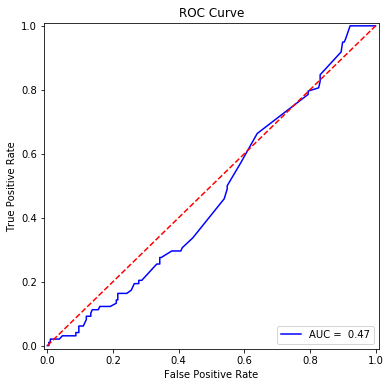

In [20]:
# Compute ROC and AUC
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = auc(fpr, tpr)

moody.plot_roc(fpr, tpr, auc_score)

### Dummy Gradient Boost Classifier

X_train = ['Amount', 'Registered_Days', 'month']

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
gb = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000)
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [23]:
gb.score(X_test, y_test)

0.6719242902208202

In [24]:
y_pred_gb = gb.predict(X_test)
print('Accuracy of GB classifier on test set: {:.2f}'.format(gb.score(X_test, y_test)))
y_prob_gb = gb.predict_proba(X_test)[:, 1]

Accuracy of GB classifier on test set: 0.67


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80       219
         1.0       0.31      0.05      0.09        98

   micro avg       0.67      0.67      0.67       317
   macro avg       0.50      0.50      0.44       317
weighted avg       0.57      0.67      0.58       317



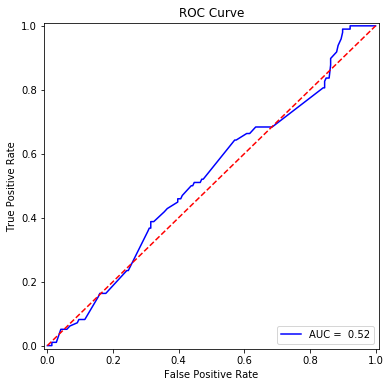

In [26]:
# Compute ROC and AUC
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_gb)
auc_score = auc(fpr, tpr)

moody.plot_roc(fpr, tpr, auc_score)

So far we actually did not do anything. Fed 2 random numerical features to the model in order to see the baseline scores.

- Baseline Estimator
- Dummy Logistic Regresion
- Dummy GB

Now we will pay more attention to EDA and do some feature engineering in order to increase model performance.  

I will try to frame most of the significant changes that increased the model performance.

That logistic model looks disgusting, so lets make it beautiful.

### Pre - Feature Engineering Phase & More EDA

### Corrolations
#### Numericals

In [27]:
df.corr().Won

Amount            -0.008167
Won                1.000000
close_year         0.039993
create_year        0.021259
Registered_Days   -0.326850
day               -0.593526
week               0.058956
month             -0.038386
Name: Won, dtype: float64

Amazing, the features that returns the higest corrolations are the engineered ones!

-  Registered_Days
- day

They both stand for day and they are both corrolated with the target. What if this is an issue of multicolinearity?

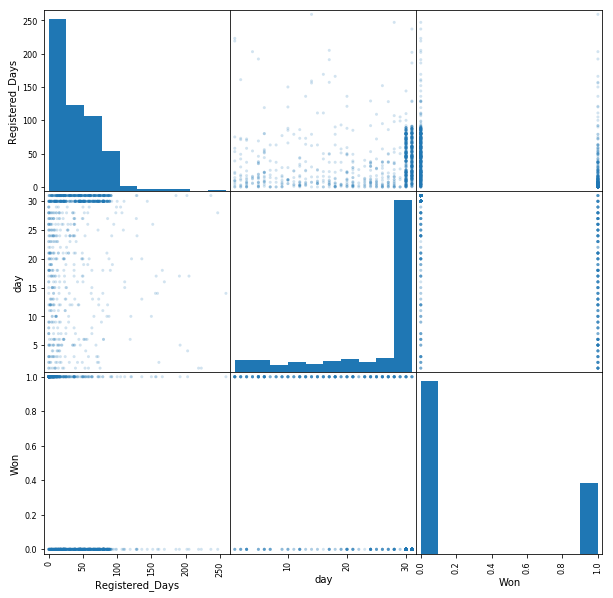

In [28]:
pd.scatter_matrix(df[['Registered_Days','day','Won']], alpha=0.2, figsize=(10, 10))
plt.show()

I see some slight collinearity there.

Lets go wilder.

## Collinearity: Variance Inflation Factor

https://en.wikipedia.org/wiki/Variance_inflation_factor

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif = df.copy()
df_vif.dropna()
df_vif = df_vif._get_numeric_data() #drop non-numeric cols

df_vif.head()

,Amount,Won,close_year,create_year,Registered_Days,day,week,month
0,18000,1.0,2018,2018,19.0,5,45,11
1,30000,0.0,2018,2018,46.0,30,26,6
2,18000,0.0,2017,2017,15.0,17,11,3
3,18000,1.0,2017,2017,0.0,28,52,12
4,30000,0.0,2018,2018,38.0,27,17,4


In [30]:
y = df_vif['Won']
X = df_vif.drop(['Won'],axis = 1)

In [31]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [32]:
vif.round(1)  #those years...

,VIF Factor,features
0,2.0,Amount
1,123765753.6,close_year
2,123789834.1,create_year
3,3.1,Registered_Days
4,9.8,day
5,7.0,week
6,9.6,month



Collinear Features

- close_year & create_year
- day & month & week

As can be see some features' VIF factors are close to each other. The reason for hat is they stand for the similar distributions.

**Next:** Try different combinations of features in order to reach a acceptable range of VIF factors.

In [33]:
y = df_vif['Won']
X = df_vif.drop(['Won','create_year','close_year','week'],axis = 1)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1) 

,VIF Factor,features
0,1.8,Amount
1,2.2,Registered_Days
2,4.9,day
3,4.0,month


Proud of my generated feaures so far;

- registered_days
- day
- month



althought there is some collinearity it won't hurt the model performance at this point.

**Logistic Regression: ['Registered_Days','day']**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days','day']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.81


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88       219
         1.0       0.82      0.51      0.63        98

   micro avg       0.81      0.81      0.81       317
   macro avg       0.82      0.73      0.75       317
weighted avg       0.81      0.81      0.80       317




**Improvement in Scoring Metrics:**

- Accuracy:          69% --> 81%
- 1.0 predictions: 0 0 0 --> 0.82      0.51      0.63  

**Changes**

- Generated 2 numerical features from create_day and close_day
- They are highly corrolated with the target
- Took some features out in accordance to VIF
- trained them to the logistic model

## Normalization & Transformations

**Registered Days**

count    1056.000000
mean       39.926136
std        35.905065
min         0.000000
25%        11.000000
50%        33.000000
75%        61.000000
max       259.000000
Name: Registered_Days, dtype: float64


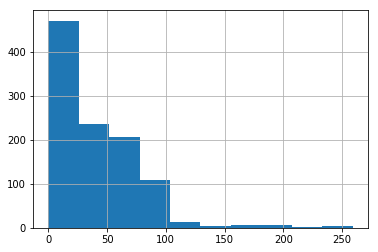

In [36]:
df_vif.Registered_Days.hist() # we don't do that here.
print(df_vif.Registered_Days.describe()) #From 75% - 61 to max - 259. Thats not ideal at all.

Our most important feature is highly skewed. Although it already contributed a lot to the model performance, we can make it contribute even more by transforming it to a normal distribution.

**day**

count    1056.000000
mean       24.627841
std         9.089066
min         1.000000
25%        20.000000
50%        30.000000
75%        31.000000
max        31.000000
Name: day, dtype: float64


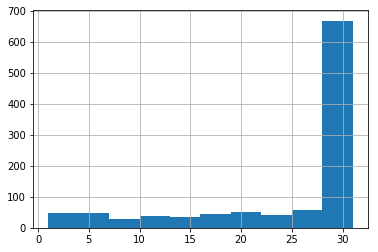

In [37]:
print(df_vif.day.describe()) #75% - 31 and max - 31? That shall change.
df_vif.day.hist() # and you, no we don't do you here as well.

**Log Transform** : Registered_Days_Log

In [38]:
df_vif['Registered_Days_Log'] = np.log((1+ df_vif['Registered_Days']))

count    1056.000000
mean        3.180736
std         1.243377
min         0.000000
25%         2.484907
50%         3.526361
75%         4.127134
max         5.560682
Name: Registered_Days_Log, dtype: float64


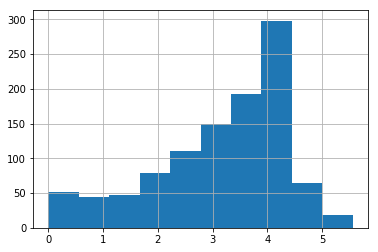

In [39]:
print(df_vif.Registered_Days_Log.describe())
df_vif.Registered_Days_Log.hist() #beautiful

**Log Transform** : day

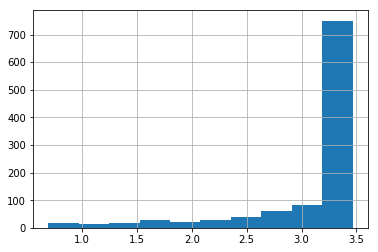

In [40]:
df_vif['day_Log'] = np.log((1+ df_vif['day']))
df_vif.day_Log.hist()

Day_log... Get out of here.

All I wanted is that normal curve.

**Percentile Linnearization** : day

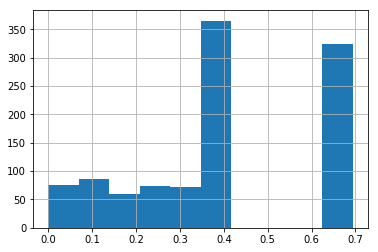

In [41]:
size = len(df_vif.day) - 1

df_vif['day_pl'] = df_vif.day.rank(method = 'min').apply(lambda x : (x-1)/size)

df_vif['day_pl'].hist()

day, even your mother doesn't like you now.

**Log Max Root:** day

In [42]:
log_max_root = np.log(df_vif.day.max())
df_vif['day_log_maxroot'] = df_vif.day ** (1/log_max_root)

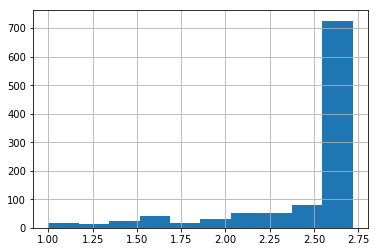

In [43]:
df_vif.day_log_maxroot.hist()

day..

It is my turn: I will categorize the days based on their corrolations with the target.

**Categorize days based on corrolations**

In [44]:
df_vif_backup = df_vif.copy()

In [45]:
def day_slice(x):
    day_hot = [18,1,5]
#     day_warm = 
    day_meh =[29,28,24,22,20,19,16,7,3]
    day_cold = [30,31]
    
    if x in day_hot:
        return "day_hot"
    elif x in day_meh:
        return 'day_meh'
    elif x in day_cold:
        return 'day_cold'
    else:
        return 'day_warm'

In [46]:
df_vif['day_corrolations'] = df_vif.day.map(day_slice)
df_vif = fun.one_hot_dummy(df_vif, ['day_corrolations'])

**Logistic Regression: **
- Log Transform: Registered_Days
- day_percentile_linearization

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_pl']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.83


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88       219
         1.0       0.83      0.55      0.66        98

   micro avg       0.83      0.83      0.83       317
   macro avg       0.83      0.75      0.77       317
weighted avg       0.83      0.83      0.82       317



**Improvement in Scoring Metrics:**

- Accuracy:          81% --> 83%
- 0.0 predictions: 0.81      0.95      0.88 --> 0.83      0.95      0.88
- 1.0 predictions: 0.82      0.51      0.63 --> 0.83      0.55      0.66

**Changes**

- Registered_days_log (log transform)
- day percentile linearization


**Logistic Regression: **
- Log Transform: Registered_Days
- day   (grouped with respect to their signal vs Won)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.86


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       219
         1.0       0.84      0.68      0.75        98

   micro avg       0.86      0.86      0.86       317
   macro avg       0.85      0.81      0.83       317
weighted avg       0.86      0.86      0.86       317



**Improvement in Scoring Metrics:**

- Accuracy:          83% --> 86%
- 0.0 predictions: 0.83      0.95      0.88 --> 0.87      0.94      0.90 
- 1.0 predictions: 0.83      0.55      0.66 --> 0.84      0.68      0.75 

Noticed that imprvement of 1.0 recall score?

**Changes**

- Registered_days_log (log transform)
- day percentile linearization


**Observations on Best Performing Logistic Model So Far:**

2 major features with the highest correlations have been used in order to predict Won == 0.

- Registered_Days_Log
- dummy variables of the day in accordance with heatmap

Result: an increase form overfit 67% accuracy to a fine-performing model with 86% accuracy.

I want to see the change

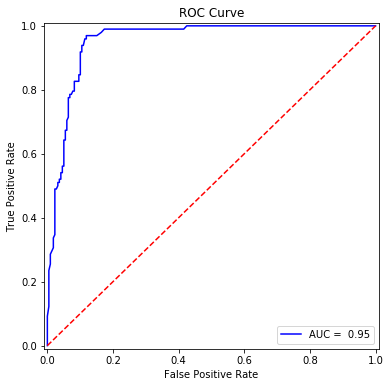

In [51]:
# Compute ROC and AUC
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = auc(fpr, tpr)

moody.plot_roc(fpr, tpr, auc_score)

### Add Month

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm','month']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.88


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       219
         1.0       0.86      0.72      0.78        98

   micro avg       0.88      0.88      0.88       317
   macro avg       0.87      0.83      0.85       317
weighted avg       0.88      0.88      0.87       317



Before:


              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       219
         1.0       0.84      0.68      0.75        98




accuracy: 86% --> 88%

**Changes:** Added month, the third strongest predictor.

I want to have a look at this one, once again.

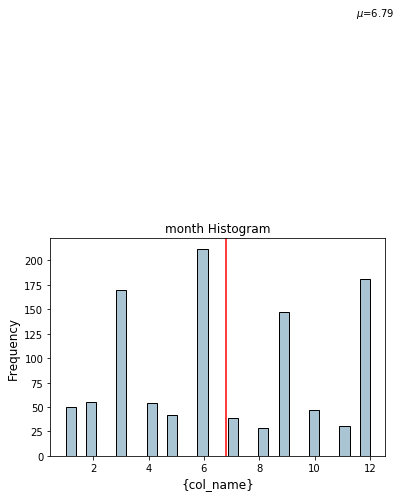

In [54]:
fun.hist_distribution(df_vif,'month')

**Dummy Month In Accordance to Heatmap**

In [55]:
def month_slice(x):
    month_hot = [5,8,11]
    month_warm = [1,4,7,10,2]
    
    if x in month_hot:
        return 'month_hot'
    elif x in month_warm:
        return 'month_warm'
    else:
        return 'month_cold'

In [56]:
df_vif['month_corr'] = df_vif.month.map(month_slice)
df_vif = fun.one_hot_dummy(df_vif, ['month_corr'])

In [57]:
df_vif.columns

Index(['Amount', 'Won', 'close_year', 'create_year', 'Registered_Days', 'day',
       'week', 'month', 'Registered_Days_Log', 'day_Log', 'day_pl',
       'day_log_maxroot', 'day_cold', 'day_hot', 'day_meh', 'day_warm',
       'month_cold', 'month_hot', 'month_warm'],
      dtype='object')

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm',
           'month_cold', 'month_hot', 'month_warm']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.87



Okay that did not work well with this one:)

Accuracy: 88% --> 87%

Changes:

- group months based on corrolations and dummy those groups


**NOTES:**

At this stage I played with Amount although it is a week predictor. Wanted to create something useful out of it because well It is money.

Amount original:

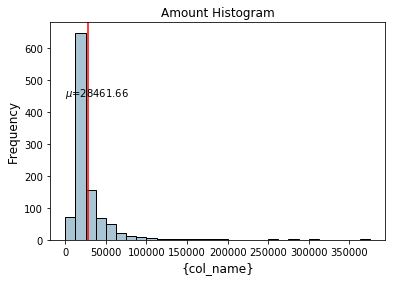

In [59]:
fun.hist_distribution(df_vif,'Amount')

- Percentile Linearization on Amount: Failure( data became distorted)
- Log Transform on Amount: (even more distorted)
- Sigmoid Function on Amount: ( I don't know what I was thinking, well certainly it did not work)
- Final Try adaptive binning a varity number of bins (model accuracy decreased by 1 %)

### Bye amount, byeeee I had enough of you.

### More Categorical Features

#### rank

In [60]:
df['rank'].head()

0    rank_unknown
1          rank_1
2    rank_unknown
3          rank_2
4          rank_3
Name: rank, dtype: object

2 options for "rank"

- binarize it (this can be usefull for logistic regression as due to dimensionality issues).
- categorize with respect to corrolations

In [61]:
def binarize_rank(x):
    if x == "rank_unknown":
        return 1
    else:
        return 0
    
def categorize_rank(x):
    if x =="rank_unknown":
        return "rank_hot"
    elif x == "rank_1":
        return "rank_meh"
    else:
        return "rank_cold"

In [62]:
df_vif['rank_binary'] = df['rank'].map(binarize_rank)
df_vif['rank_corr'] = df['rank'].map(categorize_rank)

In [63]:
df_vif = fun.one_hot_dummy(df_vif,['rank_corr'])

In [64]:
df_vif.columns

Index(['Amount', 'Won', 'close_year', 'create_year', 'Registered_Days', 'day',
       'week', 'month', 'Registered_Days_Log', 'day_Log', 'day_pl',
       'day_log_maxroot', 'day_cold', 'day_hot', 'day_meh', 'day_warm',
       'month_cold', 'month_hot', 'month_warm', 'rank_binary', 'rank_cold',
       'rank_hot', 'rank_meh'],
      dtype='object')

In [65]:
df_vif[['rank_binary','rank_cold', 'rank_hot', 'rank_meh','Won']].corr() #16% corr? I call that a supportive feature.

,rank_binary,rank_cold,rank_hot,rank_meh,Won
rank_binary,1.000000,-0.437237,1.000000,-0.297535,0.166716
rank_cold,-0.437237,1.000000,-0.437237,-0.728522,-0.130397
rank_hot,1.000000,-0.437237,1.000000,-0.297535,0.166716
rank_meh,-0.297535,-0.728522,-0.297535,1.000000,0.011439
Won,0.166716,-0.130397,0.166716,0.011439,1.000000


**Logistic Regression ADD RANK**

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm',
           'month','rank_binary']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.87


still lower than 0.88

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm',
           'month','rank_cold', 'rank_hot', 'rank_meh']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.88



- Same performance with more features. Although it didnt change a lot within the logistic regression, rankcategories may become more valuable predictors within ensamble models.

**Job Category** : Again I dummied them in accordance to their predictive power.

In [68]:
def group_jobs(x):
    if x == "n/a":
        return "hot_jobs"
    elif x in ['Tech','Product','Other','Consulting']:
        return "warm_jobs"
    elif x in ['S & M','HR']:
        return "cold_jobs"
    elif x in ['BD','Culture','Owner_Ceo']:
        return "meh_jobs"
    else:
        return "slight_cold_jobs"

In [69]:
df_vif['jobs'] = df.job_category.map(group_jobs)
df_vif = fun.one_hot_dummy(df_vif,['jobs'])

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm',
           'month','cold_jobs', 'hot_jobs', 'meh_jobs', 'slight_cold_jobs', 'warm_jobs']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.89


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       219
         1.0       0.87      0.74      0.80        98

   micro avg       0.89      0.89      0.89       317
   macro avg       0.88      0.85      0.86       317
weighted avg       0.89      0.89      0.88       317



Before:

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       219
         1.0       0.86      0.72      0.78        98
         
 Accuracy: 88% --> 89%
 
 **Changes:**
 
- Added: 'cold_jobs', 'hot_jobs', 'meh_jobs', 'slight_cold_jobs', 'warm_jobs'
 

### Lead Groups: Dummy them in accordance to corrolations again.

In [72]:
def lead_heat(x):
    if x == 'Existing Customer':
        return  x
    elif x in ['Google','MKTG']:
        return "google_mktg_lead"
    else:
        return 'other_lead'

In [73]:
df_vif['lead_group'] = df['lead_group'].map(lead_heat)
df_vif = fun.one_hot_dummy(df_vif,['lead_group'])

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = df_vif['Won']
X = df_vif[['Registered_Days_Log','day_cold', 'day_hot', 'day_meh','day_warm',
           'month','cold_jobs', 'hot_jobs', 'meh_jobs', 'slight_cold_jobs', 'warm_jobs',
           'Existing Customer', 'google_mktg_lead', 'other_lead']]


X_train, X_test, y_train, y_test_log = train_test_split(X,y, test_size=0.33, random_state=45)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_log)))
y_prob_log = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.89


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test_log, y_pred_log))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       241
         1.0       0.87      0.76      0.81       108

   micro avg       0.89      0.89      0.89       349
   macro avg       0.89      0.85      0.87       349
weighted avg       0.89      0.89      0.89       349



Before:

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       219
         1.0       0.87      0.74      0.80        98

Overal Accuracy seem to be the same. However

- 0:precision + 1 %
- 1: recall  + 2%

**Changes:** Added heatmap categorized lead groups

Note: Tried binirizing the industry groups. The model performance droped by 1%

In [76]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.263030
         Iterations 8
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.563      
Dependent Variable:        Won                    AIC:                    579.5204   
Date:                      2019-03-16 13:00       BIC:                    639.0673   
No. Observations:          1056                   Log-Likelihood:         -277.76    
Df Model:                  11                     LL-Null:                -635.66    
Df Residuals:              1044                   LLR p-value:            2.2175e-146
Converged:                 1.0000                 Scale:                  1.0000     
No. Iterations:            8.0000                                                    
-------------------------------------------------------------------------------------
                     Coef.     Std.Err.      z    P>|z|      [0.025       

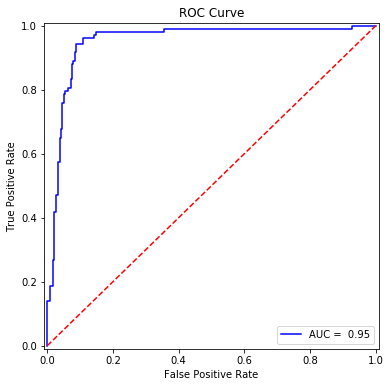

In [77]:
# Compute ROC and AUC
from sklearn.metrics import auc, roc_curve
fpr_log, tpr_log, thresholds_log = roc_curve(y_true=y_test_log, y_score=y_prob_log)
auc_score_log = auc(fpr_log, tpr_log)

moody.plot_roc(fpr_log, tpr_log, auc_score_log)

**GradientBoostingClassifier**

In [78]:
df_vif.columns

Index(['Amount', 'Won', 'close_year', 'create_year', 'Registered_Days', 'day',
       'week', 'month', 'Registered_Days_Log', 'day_Log', 'day_pl',
       'day_log_maxroot', 'day_cold', 'day_hot', 'day_meh', 'day_warm',
       'month_cold', 'month_hot', 'month_warm', 'rank_binary', 'rank_cold',
       'rank_hot', 'rank_meh', 'cold_jobs', 'hot_jobs', 'meh_jobs',
       'slight_cold_jobs', 'warm_jobs', 'Existing Customer',
       'google_mktg_lead', 'other_lead'],
      dtype='object')

In [79]:
y = df_vif['Won'].copy()
X = df_vif[['Registered_Days_Log',
               'day_cold', 'day_hot', 'day_meh','day_warm',
#            'month',
           'cold_jobs', 'hot_jobs', 'meh_jobs', 'slight_cold_jobs', 'warm_jobs', #jobs
           'Existing Customer', 'google_mktg_lead', 'other_lead',    #leads
            'month_cold', 'month_hot', 'month_warm', #month corrolation categories
#             'A_0-125Q','A_125-250Q', 'A_250-375Q', 'A_375-5Q', 'A_5-625Q', 'A_625-75Q','A_75-875Q',
#                'rank_cold', 'rank_hot','rank_meh', #adding ranks does not change anything
            ]].copy()

# Train-test split
X_train, X_test, y_train, y_test_gb = train_test_split(X, y, test_size=0.33, random_state=916)

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1000)
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [81]:
y_pred_gb = gb.predict(X_test)

In [82]:
y_pred_gb = gb.predict(X_test)
print('f1-score of GB classifier on test set: {:.2f}'.format(gb.score(X_test, y_test_gb)))
y_prob_gb = gb.predict_proba(X_test)[:, 1]

f1-score of GB classifier on test set: 0.91


In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gb, y_pred_gb))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       269
         1.0       0.77      0.84      0.80        80

   micro avg       0.91      0.91      0.91       349
   macro avg       0.86      0.88      0.87       349
weighted avg       0.91      0.91      0.91       349




              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       269
         1.0       0.77      0.84      0.80        80


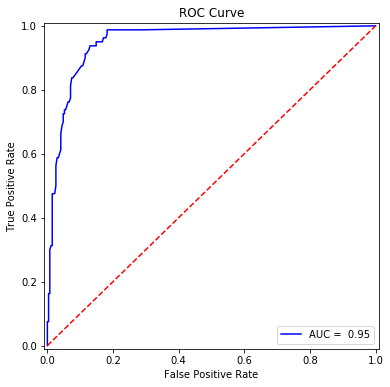

In [84]:
# Compute ROC and AUC
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_test_gb, y_score=y_prob_gb)
auc_score = auc(fpr, tpr)

moody.plot_roc(fpr, tpr, auc_score)

Looks like gradient Boosts performs the best given the engineered fearures. 

Let me proceed with the profir curve. 

# Expected Profit

### Cost Benefit Matrix


**Baseline**: Do nothing on positive predictions( TP, FP)

Reasoning behind the baseline:
- TP : Anyway juniors are going to close that deal.
- FP : Again with or without the machine learnign model, that customer is a loss.

**Assumptions**: 
- Junior Recruiters get 16% commision from succesfull deals.
- Senior Recruiters get 26% commision from succesfull deals. 
- The probability of a senior recruiter to succesffully complete the deal is 11% higher than that of a junior.

**INPUTS**
- TP: Do nothing : 0
- TN: 
On this case, the model predicted that the deal will end up as a failure.
And actually it was going to end up as a failure.

We want to change that, and thats why we plan to assign the deal to more skilled
employee, which is in our case a senior recruiter.

They cost more yet the their chances of succeding the deal is higher.

(Avg_Amount - (Avg_Amount * commision_rate))  **  senior_probability_of_success

- FP: Do nothing: 0 
- FN: Mistake there, the model predicts that the customer is a loss case for junior
recruiters and with my reccomendation the organization assigns the case to a senior staff.

However, actually juniors could close the deal and the organization would pay less in compensation.

 Avg_Amount *  (-) senior_probability_of_success














In [85]:
avg_amount = df_vif[df_vif.Amount> 0].Amount.mean()
senior_prob_of_success_diff = 0.11
prob = senior_prob_of_success_diff

In [86]:
- avg_amount

-30389.80283114257

In [87]:
tp = 0
tn = (avg_amount - (avg_amount * (0.26 - 0.16))) * 0.11  # that money is made
fp = 0
fn = - avg_amount * 0.11 # that money is gone

cost_mat = np.array([[tp, fn], [fp, tn]])
cost_mat

array([[    0.        , -3342.87831143],
       [    0.        ,  3008.59048028]])

Although the gradient boosting model performs better with 91% f-1 score compared to 89% of logistic regression. Their AUC scores are the same and there is a slight difference when it comes to ROC curves.

Reminding the fact that within crafted business case false negatives really hurts the business, I want to test both models too see which one returns a higher expected profit.

## **Profit Curve**: Logistic Regression Model

Set those tresholds.

In [88]:
from sklearn.metrics import confusion_matrix

expected_total_profit_log = []


treshholds = np.linspace(0,1,100)
for t in treshholds:
    predictions = (y_prob_log > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_log, predictions).ravel()
    conf_mat = np.array([[tp, fn], [fp, tn]])
    expected_total_profit_log.append((conf_mat * cost_mat).sum())


In [89]:
maximum_expected_profit_index_log = np.argsort(np.array(expected_total_profit_log))[-1]
expected_total_profit_log = list(np.array(expected_total_profit_log) / len(y_prob_log))
maximum_expected_profit_index_log

25

In [90]:
expected_total_profit_log[maximum_expected_profit_index_log]

1830.4413905829458

Threshold that gives the highest expected profit:0.25252525252525254


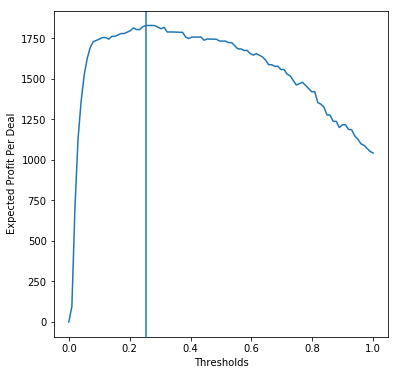

In [91]:
plt.figure(figsize=(6,6))
plt.plot(treshholds, expected_total_profit_log, label='Logistic Regression')
plt.xlabel('Thresholds')
plt.ylabel('Expected Profit Per Deal')
plt.axvline(treshholds[maximum_expected_profit_index_log])
print(f'Threshold that gives the highest expected profit:{treshholds[maximum_expected_profit_index_log]}')

On average implementing the logistic regression with regard to business strategy increases the progit by $ 1830 given treshold of 0.25.

### Profit Curve: GradientBoostClassifier

In [92]:
from sklearn.metrics import confusion_matrix

expected_total_profit_gb = []


treshholds = np.linspace(0,1,100)
for t in treshholds:
    predictions = (y_prob_gb > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_gb, predictions).ravel()
    conf_mat = np.array([[tp, fn], [fp, tn]])
    expected_total_profit_gb.append((conf_mat * cost_mat).sum())


In [93]:
maximum_expected_profit_index_gb = np.argsort(np.array(expected_total_profit_gb))[-1]
expected_total_profit_gb = list(np.array(expected_total_profit_gb) / len(y_prob_gb))
maximum_expected_profit_index_gb

49

In [94]:
expected_total_profit_gb[maximum_expected_profit_index_gb]

2022.01034825777

Threshold that gives the highest expected profit:0.494949494949495


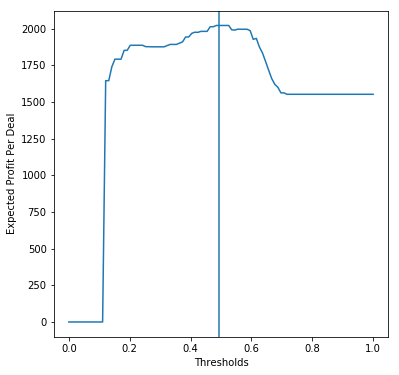

In [95]:
plt.figure(figsize=(6,6))
plt.plot(treshholds, expected_total_profit_gb, label='Logistic Regression')
plt.xlabel('Thresholds')
plt.ylabel('Expected Profit Per Deal')
plt.axvline(treshholds[maximum_expected_profit_index_gb])
print(f'Threshold that gives the highest expected profit:{treshholds[maximum_expected_profit_index_gb]}')

On average implementing the logistic regression with regard to business strategy increases the progit by $ 2022 given treshold of 0.49.


## Conclusion

With given features the gradient boost performed better in terms of both performance metrics and profits. Therefore using making use of such model in accordance to crafted business senario is expected to increase revenue per negatively predicted deal by $ 2022.

Lets find out the total expected profit increase per 1054 deals which is the number of datapoint provided for the analisis.

The profit change with influence of the ML model occurs merely with respect to True Negative and False negative predictions.

As mentioned TN increases revenue whereas FN decreases it. As we found the maximized profit per datapoint that the organization reacts, multiply that profit with the number of negative predictions shall return the expected total profit given 1100 datapoints.

- Total number of data points provided : 1054
- Total number of negative predictions(T or F in accordance to gradient boost model and 349 datapoints of test set): 269

In [102]:
Estimated_number_of_negative_predictions_per_1054 = 1054 * 269 / 349

In [103]:
Expected_total_profit_per_1054 = 2022 * Estimated_number_of_negative_predictions_per_1054

In [104]:
Expected_total_profit_per_1054

1642663.53008596

**Thoughts:** the total expected profit is higher compared to my expectations as a result of the compensation rates and 